## Model 2: Machine learning algorithm

In [247]:
#### import libraries ####
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

os.getcwd()

'C:\\Users\\offne\\Documents\\Dissertation'

## 1. Read & Clean Data

<AxesSubplot:>

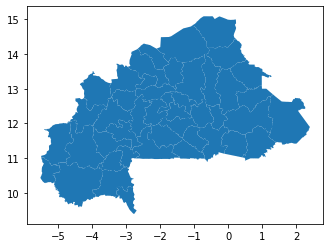

In [248]:
#### READ DATA ####
# Country shapefile (admin 2 level)
shape = gpd.read_file('Data\Shape\gadm36_BFA_2.shp')
shape = shape.drop(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2'], axis=1)
shape.rename(columns = {'NAME_2':'admin_name'}, inplace = True)
shape['admin_name'] = shape['admin_name'].astype(str)
shape.plot()


In [249]:
# FEWS CSV file
FS = pd.read_csv('Data\FS_before_after_data.csv')
FS.head()
# SARS CSV file

,country,admin_code,admin_name,centx,centy,year_month,year,month,fews_ipc,ndvi_mean,...,acled_fatalities,p_staple_food,area,cropland_pct,pop,ruggedness_mean,pasture_pct,datetime,State,Flood Date
0,Burkina Faso,303,Sissili,-2.230901,11.30098,2010_10,2010,10,1.0,0.598591,...,0,0.928518,6982.097,76.98947,226065.0,6643.468,0.0,2010-10-01,Before,2010-11-05 00:00:00
1,Burkina Faso,303,Sissili,-2.230901,11.30098,2010_12,2010,12,1.0,0.327079,...,0,0.909422,6982.097,76.98947,226065.0,6643.468,0.0,2010-12-01,After,2010-11-05 00:00:00
2,Burkina Faso,304,Ziro,-1.891305,11.63369,2010_10,2010,10,1.0,0.566632,...,0,0.943323,5329.469,79.14671,204065.0,4822.304,0.0,2010-10-01,Before,2010-11-05 00:00:00
3,Burkina Faso,304,Ziro,-1.891305,11.63369,2010_12,2010,12,1.0,0.327571,...,0,0.909559,5329.469,79.14671,204065.0,4822.304,0.0,2010-12-01,After,2010-11-05 00:00:00
4,Burkina Faso,305,Bazega,-1.454375,11.96002,2010_10,2010,10,1.0,0.487598,...,0,0.987164,3974.334,82.02844,246819.0,9551.282,0.0,2010-10-01,Before,2010-11-05 00:00:00


In [250]:
# Check strings and fix differences
l = set(FS['admin_name'].tolist())
x = set(shape['admin_name'].tolist())
print(list(l - x))
print(list(x - l))
shape['admin_name'] = shape['admin_name'].str.replace('é','e')
shape['admin_name'] = shape['admin_name'].str.replace('è','e')
shape['admin_name'] = shape['admin_name'].str.replace('Komandjoari','Komonjdjari')

['Bale', 'Kenedougou', 'Leraba', 'Sanguie', 'Kourweogo', 'Passore', 'Comoe', 'Koulpelogo', 'Bazega', 'Seno', 'Komonjdjari', 'Boulkiemde', 'Zoundweogo']
['Sanguié', 'Komandjoari', 'Kourwéogo', 'Zoundwéogo', 'Bazèga', 'Balé', 'Kénédougou', 'Séno', 'Passoré', 'Léraba', 'Koulpélogo', 'Comoé', 'Boulkiemdé']


In [274]:
# Merge data on admin_name
df = pd.merge(shape, FS, on="admin_name")
print(list(df.columns))
# Reorder columns
df = df[['country', 'admin_code', 'admin_name', 'centx', 'centy', 'Flood Date', 'State', 'datetime', 'year_month', 'year', 'month', 'fews_ipc', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'geometry']]
df = df.sort_values('admin_name')



['admin_name', 'geometry', 'country', 'admin_code', 'centx', 'centy', 'year_month', 'year', 'month', 'fews_ipc', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'datetime', 'State', 'Flood Date']


In [269]:
#### ** Matrix Transformations ** ####
# If needed


['country', 'admin_code', 'admin_name', 'Flood Date', 'State', 'datetime', 'centx', 'centy', 'year_month', 'year', 'month', 'fews_ipc', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'geometry']


## 3. Exploratory Analysis

In [254]:
#### NON SPATIAL-TEMPORAL ANALYSIS ####

# Look at data
# Examine predictive feature (few_ipc & flooding) - barplots
# Examine correlation between features and target variable - corplots

In [255]:
#### SPATIAL ANALYSIS ####

# Spatial distribution over annual average
# Check Spatial Dependency
# --> Moran's Global I
# --> Moran's Local I Clusters


In [256]:
#### TEMPORAL ANALYSIS ####

# Look at the mean few_ipc across country over time (in years)
# Look at the mean few_ipc across country over time (in months)
# Order heat map by admin food security means to examine effects
# Check Temporal Dependency
# --> ACF
# --> PACF

## 4. Model Pre-processing

In [257]:
# TIME LAGS (depends on temporal analysis)
# i.e. Add lag of 6 for general time trends
# i.e. Add lag of 12 for seasonal time trends
# !! Make sure not to include month of interest in this !!

In [258]:
# SPACE LAG
# A. Spatial weight matrix
# Queen contiguity matrix (we consider observations that share a vertex to be neighbors)
# B. Extract list of neighbors for each admin_name
# C. For each list of neighbors (nest_list), at every time interval (df_m_matrix), take the neighbors average of fews_ipc
# D. Store nested averages in final data frame

In [259]:
# RF PRE-PROCESSING
# Normalize features
# Set fews_ipc to binary classification - splitting on third quartile (depends on exploratory analysis)
# Omit NA values
# Remove unnecessary features (spatial and temporal not needed now that we have lags)

## 5. Random Forest Classification

In [260]:
#### RANDOM FOREST CLASSIFICATION ####

# A. SPLIT TRAIN/TEST SETS
# Random 70% split in train and test sets (time series is accounted for by lags)

In [261]:
# B. OPTIMISE MODEL HYPERPARAMETERS
# Hyperparameter grid search (112)


In [262]:
# C. RESULTS
# Fit optimised model
# Evaluate model
# Plot Confusion matrix
# Plot Variable importance
# Make prediction
# Calculate accuracy score